# Irradiated Monkeys
This data anlysis attempts to aply machine learning concepts to analyze the patterns and make predictions related to Rhesus monkeys housed by Wake Forest University and in collaboration with Dr. Thomas Johnson of Colorado State University and Dr. Susan Bailey of Colorado Atate Uiversity. The monkeys were irradiated with differnt doses, types, and frequencies of radiation, and blood analytics were frequently measured after radiation. The health records of the monkeys were also recorded, and all monkeys that aare iving are still being monitored. Thus, in this notebook I will test the following:
- 1.) Can machine learning cluster patterns in monkey response to radiation?
- 2.) Can machine learning make accurate blood analytic predicitons?
- 3.) Can machine learning predict the health statuses of the monkeys?
- 4.) What features contribute most to the end biomarker and prognostic statuses of the monkeys? 

# Data handling

In [1]:
# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
#import statsmodels.api as sm
import statsmodels.imputation.mice as smi
import scipy.cluster.hierarchy as hac
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#ML stuff
import catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost

#language handling
#import bert


#from mxnet import nd, autograd, gluon
#from mxnet.gluon import nn, rnn
#import mxnet as mx


print("Setup Complete")

Setup Complete


In [2]:
pwd

'/Users/aidanlew'

In [3]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [4]:
#ls

In [35]:
def parser(x):
    return datetime.datetime.strptime(x,'%d-%m-%y')

In [39]:
#Makee a df were all the data is present (except irrad data for the controls)
solid_monkey_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    #sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
solid_monkey_df.set_index(['ID'])
solid_monkey_df['ID'] = solid_monkey_df['ID'].astype(str)

#solid_monkey_df.dropna(axis=0, inplace=True) 

solid_monkey_df.columns
#solid_monkey_df.tail()

Index(['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
      dtype='object')

In [7]:
# See our monkey sample size
print('Total Monkeys:{}'.format(solid_monkey_df['ID'].nunique()))
 
# Count the control monkeys
print('Non-Irradiated Samples:{}'.format(solid_monkey_df['IRRAD'].value_counts()['No']))
 
# Count the irradiated monkeys
print('Irradiated Samples:{}'.format(solid_monkey_df['IRRAD'].value_counts()['Yes']))

Total Monkeys:272
Non-Irradiated Samples:970
Irradiated Samples:3582


## We have 272 monkeys, 31 variables, and 4552 sample dates – get stoked
May need to add some of the monkeys that had missing data, but it's robust enough at the moment


# Vizualization
    1.) See the blood analytics over time for each monkey
    2.) See the ages of the monkeys
        a.) For the absolute age
        b.) For age at irrad
        c.) For time since irrad

In [8]:
solid_monkey_df.columns

Index(['ID', 'Species', 'SAMPLE_DATE', 'IRRAD ', 'IRRAD_DATE', 'DOSE_(Gy)',
       'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD', 'DOB',
       'SEX', 'AGE', 'TYPE', 'WBC_(K/uL)', 'RBC_(M/uL)',
       'Hemaglobin_(HGB_g/dL)', 'Hemocrit_(HCT_%)',
       'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
      dtype='object')

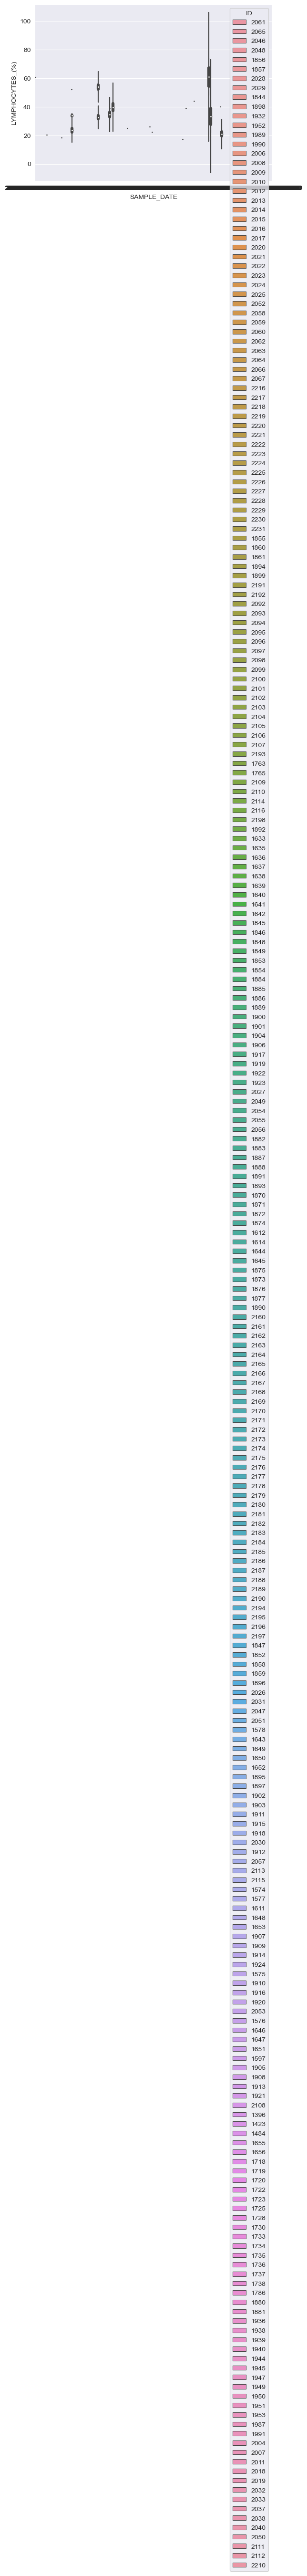

In [9]:
# Make a violin plot for all monkeys
sns.violinplot(data=solid_monkey_df, x="SAMPLE_DATE", y="LYMPHOCYTES_(%)", hue="ID",
               #split=True, inner="quart", linewidth=1,
               #palette={"Yes": "b", "No": ".85"}
              )
sns.despine(left=True)

In [ ]:
# Trying to viz one monkey's changes over time
sns.lineplot(x="SAMPLE_DATE", y="LYMPHOCYTES_(%)",
             hue="ID", 
             #style="event",
             data=solid_monkey_df)

In [ ]:
#See the distribution of Age
plt.figure(figsize=(5,5))

sns.histplot(
    solid_monkey_df,
    x="AGE", 
    #hue="",
    #multiple="stack",
    palette="light:m_r",
    #edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
)

In [ ]:
#See the distribution of Sample Age
plt.figure(figsize=(5,5))
sns.histplot(
    solid_monkey_df,
    x='DAYS_SINCE_IRRAD', 
    #hue="",
    #multiple="stack",
    palette="light:m_r",
    #edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
)

In [ ]:
#See the distribution of Sample Age
plt.figure(figsize=(5,5))

sns.histplot(
    solid_monkey_df,
    x='MONTHS_SINCE_IRRAD', 
    #hue="",
    #multiple="stack",
    palette="light:m_r",
    #edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
)

In [ ]:
#See the distribution of Sample Age
plt.figure(figsize=(5,5))

sns.histplot(
    solid_monkey_df,
    x='MONTHS AT IRRAD', 
    #hue="",
    #multiple="stack",
    palette="light:m_r",
    #edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
)

### Immediately there's no use in visualizing with typical plots that handle only a few variables
 - Viz with UMAP
 - Viz with other high-quantitiy plots
 - Viz with facet grids 

# Machine Learning Magic
https://catboost.ai/en/docs/



## 1.) Can machine learning cluster patterns in monkey response to radiation?



## UMAP
 - Cluster blood analytics
 - Cluster other stuff?
 
See the docs here: https://umap-learn.readthedocs.io/en/latest/index.html



### Blood analytic UMAP
See all of the blood samples and how they cluster

#### Simple UMAP


In [72]:
# Same setup as from the docs example: https://umap-learn.readthedocs.io/en/latest/basic_usage.html
import umap.plot
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

import umap
reducer = umap.UMAP()


print('Setup Complete')

Setup Complete


In [74]:
#need to scale the vales to z-scores to get them all on the same page

#Make df with the blood analytics with no missing values
solid_monkey_df.copy()
blood_monkey_df = solid_monkey_df[['ID','WBC_(K/uL)', 'RBC_(M/uL)',
       'Hemaglobin_(HGB_g/dL)', 'Hemocrit_(HCT_%)',
       'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)']].dropna()

#blood_monkey_df.head()

#Scale the blood to z-scores
blood_umap_df = blood_monkey_df[
    [
        'WBC_(K/uL)', 'RBC_(M/uL)',
       'Hemaglobin_(HGB_g/dL)', 'Hemocrit_(HCT_%)',
       'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'
    ]
].values
scaled_blood_df= StandardScaler().fit_transform(blood_umap_df)

In [75]:
# Want it to be (n, 2) for UMAP to work
embedding = reducer.fit_transform(scaled_blood_df)
embedding.shape

(4552, 2)

In [76]:
#Umap needs ID to be an intiger, not str
blood_monkey_df['ID'] = blood_monkey_df['ID'].astype(int)

In [79]:
mapper = umap.UMAP().fit(scaled_blood_df)


Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

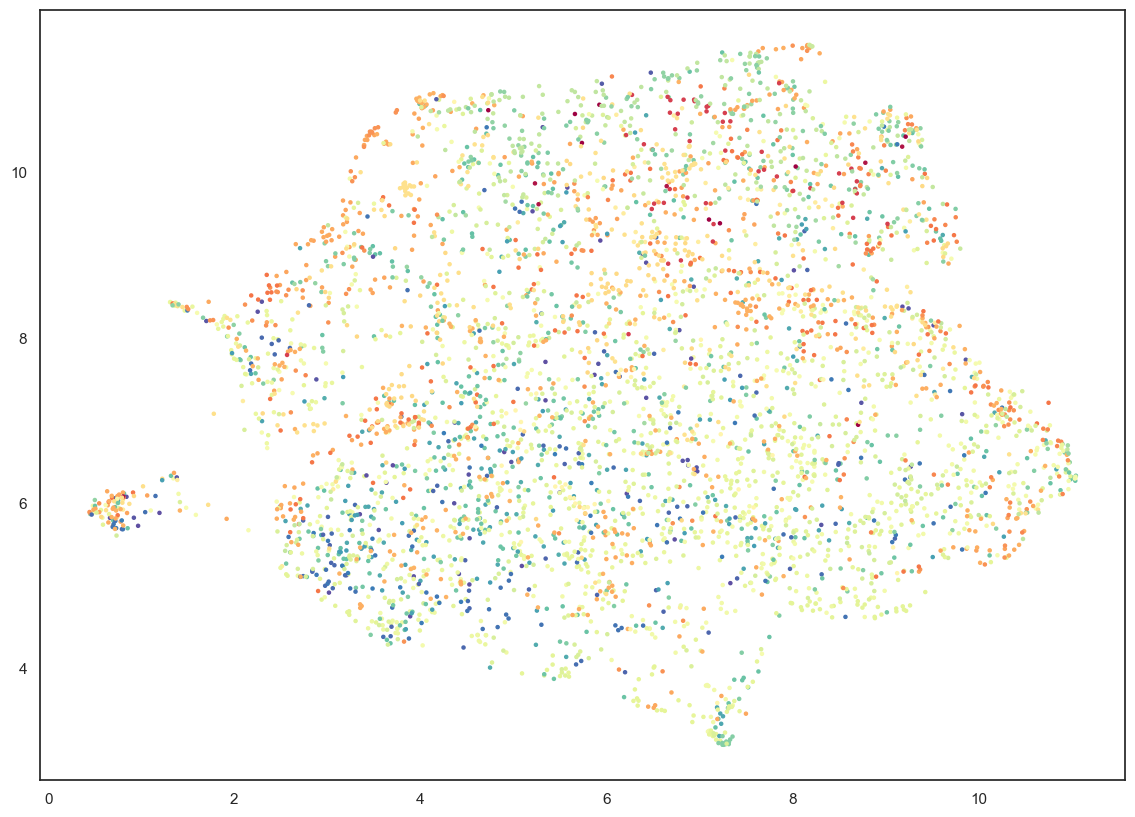

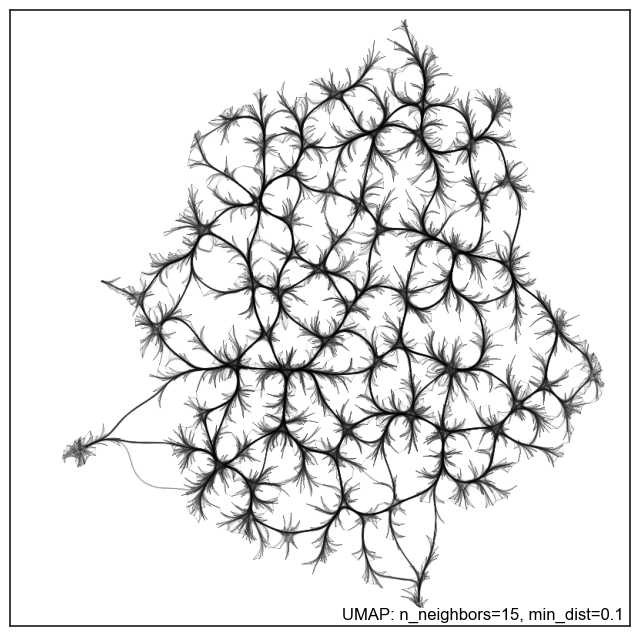

In [80]:
# Simply visualize the UMAP
plt.scatter(embedding[:, 0], 
            embedding[:, 1], 
            c=blood_monkey_df.ID, 
            cmap='Spectral', 
            s=5
           )
#show the spiderweb
#umap.plot.connectivity(mapper, edge_bundling='hammer')

plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('ID not a Feature: UMAP projection of the Blood Analytics', fontsize=24);

In [17]:
#need to scale the vales to z-scores to get them all on the same page

#Make df with the blood analytics with no missing values
solid_monkey_df.copy()
blood_monkey2_df = solid_monkey_df[['ID','WBC_(K/uL)', 'RBC_(M/uL)',
       'Hemaglobin_(HGB_g/dL)', 'Hemocrit_(HCT_%)',
       'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)']].dropna()

#blood_monkey_df.head()

#Scale the blood to z-scores
blood_umap2_df = blood_monkey_df[
    [
        'ID', 'WBC_(K/uL)', 'RBC_(M/uL)',
       'Hemaglobin_(HGB_g/dL)', 'Hemocrit_(HCT_%)',
       'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'
    ]
].values
scaled_blood2_df= StandardScaler().fit_transform(blood_umap2_df)

In [18]:
embedding2 = reducer.fit_transform(scaled_blood_df)
embedding2.shape

(4552, 2)

In [19]:
#Umap needs ID to be an intiger, not str
blood_monkey2_df['ID'] = blood_monkey2_df['ID'].astype(int)

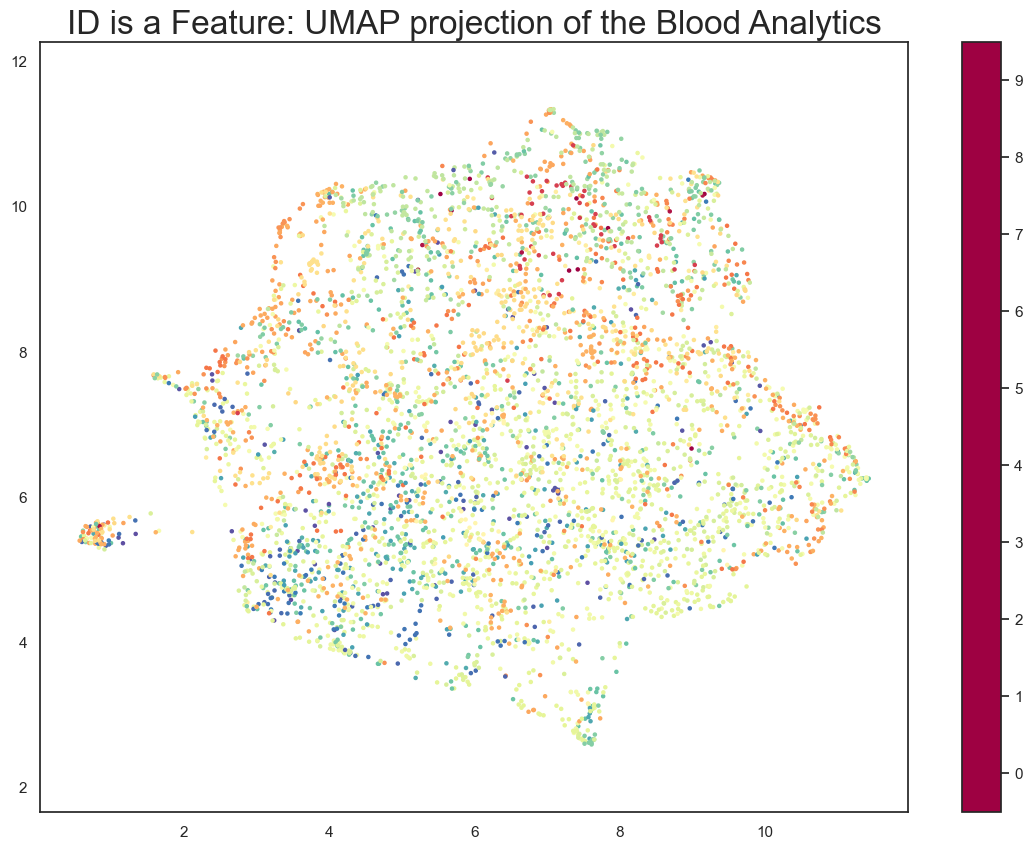

In [20]:
# Simply visualize the UMAP
plt.scatter(embedding2[:, 0], 
            embedding2[:, 1], 
            c=blood_monkey2_df.ID, 
            cmap='Spectral', 
            s=5
           )
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('ID is a Feature: UMAP projection of the Blood Analytics', fontsize=24);

#### Interactive UMAP to see the ID's for each cluster
- it looks like there are at least three different clusters, we want to know which ones are similar
- also find out how to parse them numerically

In [21]:
from io import BytesIO
from PIL import Image
import base64

In [22]:
def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.Resampling.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

In [23]:
import bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

output_notebook()

Loading BokehJS ...

In [ ]:
umap1_df = pd.DataFrame(embedding, columns=('x', 'y'))

datasource = ColumnDataSource(umap1_df)
color_mapping = CategoricalColorMapper(factors=blood_monkey_df.ID,
                                       palette='Turbo256')




plot_figure = figure(
    title='UMAP projection of the Digits dataset',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@digit</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='digit', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)
show(plot_figure)

### It works, but the number of points is so large it gives them all grey colors, might work with just monkeys ###

### Monkey UMAP

## 2.) Can machine learning make accurate blood analytic predicitons?

### Catboost Data setup

In [26]:
import os
np.set_printoptions(precision=4)
import catboost as ctb
print('setup complete')

setup complete


In [40]:
solid_monkey_df.tail(2)

,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
4550,2210,Rhesus-Indian,2021-09-20 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,36.2,10.9,1.7,0.0,2970,2100,632,99,0,348
4551,2210,Rhesus-Indian,2021-10-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,16.0,21.0,3.0,0.0,3360,896,1176,168,0,329


In [41]:
#make a parent df
solid_monkey_df.copy()
blood_ML_df = solid_monkey_df
blood_ML_df.tail(2)

,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
4550,2210,Rhesus-Indian,2021-09-20 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,36.2,10.9,1.7,0.0,2970,2100,632,99,0,348
4551,2210,Rhesus-Indian,2021-10-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,16.0,21.0,3.0,0.0,3360,896,1176,168,0,329


In [42]:
#make train/testdf
(train_df, test_df)= blood_ML_df, blood_ML_df

#train_df.tail(2) 
test_df.tail(2)

,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
4550,2210,Rhesus-Indian,2021-09-20 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,36.2,10.9,1.7,0.0,2970,2100,632,99,0,348
4551,2210,Rhesus-Indian,2021-10-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,16.0,21.0,3.0,0.0,3360,896,1176,168,0,329


In [54]:
# label values extraction
#ctb not messing with datetime at the moment
y=train_df.ID
X=train_df.drop(['ID','IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)

#y.tail()
X.columns

Index(['Species', 'IRRAD', 'SEX', 'TYPE', 'DAYS_SINCE_IRRAD',
       'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD', 'DOSE_(Gy)', 'AGE',
       'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)', 'Hemocrit_(HCT_%)',
       'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
      dtype='object')

In [52]:
###needs to be np_array??? ###

# Declare catagorical features - firt 0-3 columns 
cat_features= list(range(0,X[X.columns[:4]].shape[1]))

print(cat_features)

# all of our labels are catagorical

[0, 1, 2, 3]


In [55]:
from catboost import Pool
from sklearn.model_selection import train_test_split

#put the data into the pool
pool = Pool(data=X, label=y, cat_features=cat_features)


#train tesr split - 20% test
data= train_test_split(X,y, test_size=0.2, random_state=0)

#### The order of this matters###
X_train,  X_validation, y_train, y_validation= data

train_pool = Pool(
    data = X_train,
    label = y_train,
    cat_features = cat_features
)

validation_pool = Pool(
    data = X_validation,
    label = y_validation,
    cat_features = cat_features
)

### Primary Model Formation

In [56]:
from catboost import CatBoostClassifier
model= CatBoostClassifier(iterations=100)
model.fit(X,y,cat_features=cat_features, verbose=10 #tells how many iterations to print
         )

Learning rate set to 0.5
0:	learn: 5.0013965	total: 12.9s	remaining: 21m 18s
10:	learn: 1.8014726	total: 2m 17s	remaining: 18m 30s
20:	learn: 0.9969018	total: 4m 13s	remaining: 15m 54s
30:	learn: 0.5636723	total: 6m 33s	remaining: 14m 34s
40:	learn: 0.4297122	total: 8m 36s	remaining: 12m 22s
50:	learn: 0.3286199	total: 10m 44s	remaining: 10m 19s
60:	learn: 0.2701668	total: 12m 49s	remaining: 8m 12s
70:	learn: 0.2212163	total: 14m 57s	remaining: 6m 6s
80:	learn: 0.1888019	total: 17m 4s	remaining: 4m
90:	learn: 0.1582650	total: 18m 52s	remaining: 1m 52s
99:	learn: 0.1394621	total: 20m 30s	remaining: 0us


In [69]:
#making the model

#SHAPSHOTTING: uncoment below to use, then recomment to resume
#!rm '/catboost_info/snapshot.bkp'


#need 'Multiclass'
model2 = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.5,
    loss_function='MultiClass',
    custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=20,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    snapshot_interval=120
)


#plot while fitting
model2.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params;\n{}'.format(model.get_params()))
print(model2.tree_count_)

# saving the model
model.save_model('catboost_model.bin')
model.save_model('monkey_catboost_model.json', format='json')
### If it runs fully it will take about 5 hours###

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model is fitted: True
Model params;
{'iterations': 100}
722


In [93]:
model.load_model('catboost_model.bin')

### Hyperparam tuning
Looks like 723 iterations of a 0.5 learning rate is pretty good - 0.59 multiclass loss 
Let's see how we can better form the model

In [92]:
import optuna
from optuna._experimental import experimental
from optuna._imports import try_import

from optuna.integration  import CatBoostPruningCallback


from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def objective(trial: optuna.Trial) -> float:
    data, target = X, y
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.2)

    param = {
        "objective": trial.suggest_categorical("objective", ["MultiClass", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "Accuracy",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = ctb.CatBoostClassifier(**param)

    pruning_callback = CatBoostPruningCallback(trial, "Accuracy")
    gbm.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)

    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
    )
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


ImportError: cannot import name 'CatBoostPruningCallback' from 'optuna.integration' (unknown location)

## 3.) Can machine learning predict the health statuses of the monkeys?

## 4.) What features contribute most to the end biomarker and prognostic statuses of the monkeys?

# Conclusions